In [1]:
#!pip install --upgrade oct2py
import numpy as np
from oct2py import octave
import matplotlib.pyplot as plt
import os
import pandas as pd
octave.addpath('C:/dynare/6.1/matlab')  
#octave.addpath('/opt/homebrew/opt/dynare/lib/dynare/matlab')

    _pyeval at line 57 column 30

    _pyeval at line 57 column 30



'.;C:\\Users\\blankenw\\AppData\\Local\\anaconda3\\Lib\\site-packages\\oct2py;C:\\Users\\blankenw\\AppData\\Local\\anaconda3\\Lib\\site-packages\\octave_kernel;C:\\Program Files\\GNU Octave\\Octave-9.1.0\\mingw64\\lib\\octave\\9.1.0\\site\\oct\\x86_64-w64-mingw32;C:\\Program Files\\GNU Octave\\Octave-9.1.0\\mingw64\\lib\\octave\\site\\oct\\api-v59\\x86_64-w64-mingw32;C:\\Program Files\\GNU Octave\\Octave-9.1.0\\mingw64\\lib\\octave\\site\\oct\\x86_64-w64-mingw32;C:\\Program Files\\GNU Octave\\Octave-9.1.0\\mingw64\\share\\octave\\9.1.0\\site\\m;C:\\Program Files\\GNU Octave\\Octave-9.1.0\\mingw64\\share\\octave\\site\\api-v59\\m;C:\\Program Files\\GNU Octave\\Octave-9.1.0\\mingw64\\share\\octave\\site\\m;C:\\Program Files\\GNU Octave\\Octave-9.1.0\\mingw64\\share\\octave\\site\\m\\once_only;C:\\Program Files\\GNU Octave\\Octave-9.1.0\\mingw64\\share\\octave\\site\\m\\startup;C:\\Program Files\\GNU Octave\\Octave-9.1.0\\mingw64\\lib\\octave\\9.1.0\\oct\\x86_64-w64-mingw32;C:\\Program Fi

In [2]:
n_goods=9

In [3]:
with open('t_call.m', 'w') as file:
    file.write("stoch_simul(nograph, order=1, periods=1000, irf=100);")

In [4]:
%run make_model.ipynb
%run make_vars.ipynb
%run make_parameters_and_shocks.ipynb
%run make_steady_state_3.ipynb


Makes a call to Octave, which makes a call to Dynare. Then the `.mod` file is run in Dynare. Output from Dynare is displayed as it runs.

In [5]:
octave.dynare('model_1.mod')
oo = octave.pull('oo_')
mm = octave.pull('M_')

Starting Dynare (version 6.1).
Calling Dynare with arguments: none
Starting preprocessing of the model file ...
Found 24 equation(s).
Evaluating expressions...
Computing static model derivatives (order 1).
Normalizing the static model...
Finding the optimal block decomposition of the static model...
19 block(s) found:
  18 recursive block(s) and 1 simultaneous block(s).
  the largest simultaneous block has 6 equation(s)
                                 and 6 feedback variable(s).
Computing dynamic model derivatives (order 1).
Normalizing the dynamic model...
Finding the optimal block decomposition of the dynamic model...
2 block(s) found:
  1 recursive block(s) and 1 simultaneous block(s).
  the largest simultaneous block has 6 equation(s)
                                 and 6 feedback variable(s).
Preprocessing completed.
Preprocessing time: 0h00m00s.

STEADY-STATE RESULTS:

c      		 0.186403
i      		 0.358507
k      		 1.27678
y      		 0.446873
n0     		 -1.15537
s0     		 -1.155

In [6]:
names1 = [attr for attr in dir(oo) if not attr.startswith('__')]

Now we want to create a class where each each attribute in oo becomes an attribute of this class. So far we take only one item from mm. This is a list of endogenous variables. Below we define the class. 

In [7]:
class from_octave:
	def __init__(self, oo_structure, mm_structure, attribute_names):
		self.oo_structure = oo_structure
		self.mm_structure = mm_structure
		self. attribute_names =  attribute_names
		self.create_attributes()
		self.make_list()
     
	def create_attributes(self): 
		for attr in self.attribute_names:
			setattr(self, attr, getattr(self.oo_structure, attr)) #this is the attributes we pull from the oo structure. We are making them attributes of the class
	
	def make_list(self): 
		self.names = list(getattr(self.mm_structure, 'endo_names')) #getting one item from the mm structure. This is the endo_names
		self.names = [item[0] for item in self.names] #pulling mm gives us a list of cell arrays. We are pulling the first item from each cell array

We see that we now can reference any of the data from `oo` with the `tt.` notation. Some examples are below. 

In [8]:
tt = from_octave(oo, mm, names1)

In [9]:
dir(tt)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_is_allowed',
 'attribute_names',
 'autocorr',
 'clear',
 'copy',
 'create_attributes',
 'dr',
 'dynare_version',
 'endo_simul',
 'exo_det_simul',
 'exo_det_steady_state',
 'exo_simul',
 'exo_steady_state',
 'fromkeys',
 'get',
 'gui',
 'initial_exo_steady_state',
 'initial_steady_state',
 'initval_series',
 'irfs',
 'items',
 'keys',
 'kurtosis',
 'make_list',
 'mean',
 'mm_structure',
 'names',
 'oo_structure',
 'pop',
 'popitem',
 'setdefault',
 'skewness',
 'steady_state',
 'time',
 'update',
 'values',
 'var',
 'var_list',
 'variance_decomposition']

We will care about the irfs but these are also of type `oct2py.io.Struct`. We convert it as above. We will likley make this part of the above class later, but for now we create a new class. 

In [10]:
names2 = [attr for attr in dir(tt.irfs) if attr.endswith('shock')]
#names2 = [x for _, x in sorted(zip(tt.names, names2), key=lambda pair: pair[0][0])]

I will put more desciptors here later. However, it is getting the impulse responses as difference and levels. It is simultanosuly creating two dataframes containing all differences and levels data.  

In [11]:
#recall make_levels is created in simpler ffolder
import numpy as np
import pandas as np
class make_irfs:
	def __init__(self, dta, vars, names):
		self.data = dta
		self.vars = vars
		self.names = names
		self.create_difs()
		
  	
	def create_difs(self):
		for var in self.vars:
			setattr(self, var, pd.DataFrame())  # Initialize an empty DataFrame with the dynamic name
			list_short = [name for name in self.names if name.startswith(var)]
			for attr in list_short:
				x = getattr(self.data, attr)
				x = x.flatten()
				getattr(self, var)[attr] = x  # Assign the flattened array to the DataFrame
				new_columns = [col.replace(var + '_', '').replace('shock', '') for col in getattr(self, var).columns]
				getattr(self, var).columns = new_columns
    
    



In [12]:
varlist=['c','i','y','k','n0','s0']

In [13]:
ir = make_irfs(tt.irfs,varlist, names2)
print(ir.__dict__.keys())

dict_keys(['data', 'vars', 'names', 'c', 'i', 'y', 'k', 'n0', 's0'])


In [14]:
dir(ir)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'c',
 'create_difs',
 'data',
 'i',
 'k',
 'n0',
 'names',
 's0',
 'vars',
 'y']

Lets get a sense of what we have. 

This will also need more documentation, but it is getting the results of dynare's simulation. It defines the individual series and also puts all in a dataframe. 

In [15]:
import numpy as np

class make_data:
	def __init__(self, dta,names):
		self.data = dta
		self.names = names
		self.make_levels()
		self.make_raw()

	def make_raw(self):
		self.df_raw = pd.DataFrame()  # Initialize an empty DataFrame
		for j,attr in enumerate(self.names):
			attr=self.names[j]
			new_attr =attr + 'r'
			raw_level = self.data[j]
			setattr(self, new_attr, raw_level)
			self.df_raw[new_attr] = raw_level
			
  		
	def make_levels(self):
		self.df = pd.DataFrame()  # Initialize an empty DataFrame
		for j,attr in enumerate(self.names):
			attr=self.names[j]
			raw_level = self.data[j]
			if attr != 'i' and 'theta' not in attr:
				current_level=np.exp(raw_level)
			else:
				current_level=raw_level
			setattr(self, attr, current_level)
			self.df[attr] = current_level  # Store in DataFrame



In [16]:
eg=make_data(tt.endo_simul,tt.names)

In [17]:
eg.df

,c,i,k,y,n0,s0,theta0,theta1,theta2,theta3,...,theta8,a0,a1,a2,a3,a4,a5,a6,a7,a8
0,1.208680,0.390832,3.617544,1.599927,0.319311,0.343998,0.371435,0.336633,0.357333,0.341169,...,0.346782,0.993434,0.965689,1.067394,0.989659,0.988691,1.048426,0.866614,1.068811,0.992697
1,1.114317,0.358727,3.614505,1.472225,0.327005,0.337067,0.356040,0.351385,0.359877,0.355634,...,0.330361,0.896572,1.058217,0.883984,1.000385,1.194059,0.869474,0.978007,1.204920,1.057572
2,1.247791,0.351118,3.604115,1.598552,0.304816,0.309471,0.348926,0.357884,0.345159,0.360292,...,0.309360,1.032416,1.064876,0.883120,0.910723,1.504784,0.866905,1.012271,1.192984,1.072709
3,1.307987,0.287281,3.531345,1.591341,0.284732,0.253355,0.307207,0.357684,0.364606,0.362388,...,0.292359,1.114540,1.002859,0.777394,0.896614,1.296252,1.039464,1.051686,1.227649,0.898517
4,1.229603,0.221144,3.403736,1.454479,0.278946,0.225140,0.269926,0.362426,0.337036,0.360867,...,0.296150,1.055804,0.812092,0.845351,0.854872,1.224099,1.028557,0.972879,1.257714,0.915462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.870852,0.293583,2.860245,1.167790,0.349111,0.333287,0.310772,0.348555,0.281047,0.315927,...,0.326350,0.780746,0.719148,1.030809,1.692993,0.515740,0.546755,0.478339,1.559724,1.919111
996,0.856492,0.296558,2.875466,1.155117,0.355387,0.333154,0.310304,0.370699,0.312454,0.310419,...,0.292985,0.766400,0.735755,0.943567,1.588435,0.551632,0.566850,0.464788,1.195615,1.874090
997,0.976486,0.322630,2.910322,1.299431,0.337760,0.323075,0.320379,0.369834,0.299828,0.325487,...,0.316254,0.898003,0.776511,0.955919,1.696925,0.544345,0.581266,0.459555,1.042312,1.662370
998,0.952395,0.293521,2.918262,1.251142,0.333645,0.308248,0.306354,0.373148,0.303196,0.313354,...,0.308899,0.865209,0.719133,1.098531,1.635584,0.535874,0.653227,0.444077,0.983770,1.439641


In [18]:
eg.df.describe()

,c,i,k,y,n0,s0,theta0,theta1,theta2,theta3,...,theta8,a0,a1,a2,a3,a4,a5,a6,a7,a8
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.180848,0.357101,3.601735,1.528263,0.336433,0.336377,0.350504,0.348966,0.351811,0.355280,...,0.351809,0.980918,1.080013,0.694963,1.000132,1.982597,1.257701,0.937557,0.891704,1.455199
std,0.434643,0.061772,0.421832,0.462312,0.067865,0.074898,0.040952,0.035862,0.034155,0.039532,...,0.039080,0.409437,0.681017,0.416654,0.601378,1.299826,0.671641,0.549643,0.564120,0.893825
min,0.400518,0.108084,2.679291,0.648587,0.214610,0.158575,0.189788,0.252642,0.253060,0.219861,...,0.228051,0.303111,0.196264,0.115324,0.266603,0.207059,0.230522,0.174209,0.123305,0.299068
25%,0.848987,0.317443,3.324134,1.175481,0.280298,0.278862,0.323721,0.324095,0.329275,0.332205,...,0.323995,0.673743,0.569519,0.400930,0.579037,0.877263,0.760237,0.506949,0.441311,0.912489
50%,1.086325,0.357673,3.593907,1.435418,0.335065,0.325945,0.350028,0.348314,0.350446,0.354688,...,0.352127,0.886237,0.897582,0.624505,0.803289,1.751576,1.060583,0.839440,0.783110,1.220124
75%,1.492493,0.396471,3.817257,1.868337,0.377508,0.390539,0.374824,0.374676,0.373859,0.380721,...,0.378707,1.257846,1.444626,0.905064,1.263276,2.868620,1.643651,1.265962,1.219707,1.676627
max,2.491845,0.553766,4.993089,2.957025,0.573317,0.592722,0.490917,0.442341,0.458677,0.484674,...,0.474520,2.410279,4.345310,2.920544,3.867731,6.208024,3.780215,3.333088,3.008643,6.559652


In [19]:
def x_find(g,tt):
    thetag='theta'+str(g)
    ag='a'+str(g)
    omegag='omega'+str(g)
    thetai=eg.df[thetag][tt]
    theta0=eg.df['theta0'][tt]
    
    
    ai=eg.df[ag][tt]
    a0=eg.df['a0'][tt]
    k=eg.df['k'][tt-1]
    s0=eg.df['s0'][tt]
    n0=eg.df['n0'][tt]
    theta0=eg.df['theta0'][tt]
    eps=params['eps']
    omegai=params[omegag]
    omega0=params['omega0']
    
    x=(k*s0/n0)**((theta0-thetai)*(1-eps))*(omegai/omega0)**eps* \
    ((a0)**(1-theta0)/(ai)**(1-thetai)*(theta0/thetai)**thetai*((1-theta0)/(1-thetai))**(1-thetai))**(1-eps)
    
    return x

In [20]:
def X_find(t):
    X=0
    for g in range(0,n_goods):
        X+=x_find(g,t)
    return X

In [21]:
def Z_find(t):
    Z=0
    for g in range(0,n_goods):
        thetag='theta'+str(g)
        thetai=eg.df[thetag][t]
        Z+=x_find(g,t)*thetai
    return Z

In [22]:
eg.df['X'] = [X_find(t) if t > 0 else np.nan for t in range(eg.df.shape[0])]
eg.df['Z'] = [Z_find(t) if t > 0 else np.nan for t in range(eg.df.shape[0])]
eg.df['Q']=(eg.df['Z']-eg.df['theta0']*eg.df['X'])/eg.df['X']

In [23]:
def n_i(tt,g):
    
    thetag='theta'+str(g)
    thetai=eg.df[thetag][tt]
    theta0=eg.df['theta0'][tt]
    y=eg.df['y'][tt]
    c=eg.df['c'][tt]
    X=eg.df['X'][tt]
    Q=eg.df['Q'][tt]
    
    xi=x_find(g,tt)
    if g>0:
        ni=xi/X*c/y*(1-thetai)/(1-theta0-c/y*Q)
        
        #check this above..should be theta0 or thetai on bottom??
    else:
        ni=(1-theta0)*(1-c/y*(1-xi/X))/(1-theta0-c/y*Q)
  
    return ni

In [24]:
def check_sum_ni_theata(tt):
    nit=0
    theta0=eg.df['theta0'][tt]
    y=eg.df['y'][tt]
    c=eg.df['c'][tt]
    Q=eg.df['Q'][tt]
    for g in range(0,n_goods):
        thetag='theta'+str(g)
        nit+=n_i(tt,g)/(1-eg.df[thetag][tt])    
        
    return nit-1/(1-theta0-(c/y)*Q)

In [25]:
def check_sum_ni(tt):
    nit=0
    theta0=eg.df['theta0'][tt]
    y=eg.df['y'][tt]
    c=eg.df['c'][tt]
    Q=eg.df['Q'][tt]
    for g in range(0,n_goods):
        nit+=n_i(tt,g)
        
    return nit-1 

In [26]:
def py_n(tt,g):
    
    thetag='theta'+str(g)
    thetai=eg.df[thetag][tt]
    theta0=eg.df['theta0'][tt]
    a0=eg.df['a0'][tt]
    s0=eg.df['s0'][tt]
    n0=eg.df['n0'][tt]
    k=eg.df['k'][tt-1]
    prod=(1-theta0)*a0**(1-theta0)*k**theta0*(s0/n0)**theta0/(1-thetai)
    #note this has been divived by *n_i(tt,g)
    return prod
    

In [27]:

def within_find(tt):
    within=0
    ylag=eg.df['y'][tt-1]
    a=eg.df['a0'][tt]/eg.df['a0'][tt-1]
    ac=eg.df['a0'][tt]
    alag=eg.df['a0'][tt-1]
    for g in range(0,n_goods):
        #withing=(ac*py_n(tt,g)-alag*py_n(tt-1,g))*n_i(tt-1,g)
        #withing = np.log(ac * py_n(tt, g))*n_i(tt-1,g) - np.log(alag * py_n(tt - 1, g))*n_i(tt-1,g)
        withing = np.log(ac*py_n(tt, g)/(alag * py_n(tt - 1, g)))*n_i(tt-1,g)*(alag * py_n(tt - 1, g))
        within+=withing 
    #return within/(ylag*alag)
    return within/(alag*ylag)

In [28]:

def static_find(tt):
    static=0
    N=0
    N_minus=0
   
    ylag=eg.df['y'][tt-1]
    
    for g in range(0,n_goods):
       
        staticg=(n_i(tt,g)-n_i(tt-1,g))*py_n(tt-1,g)
        
        
        N+=n_i(tt,g)
        N_minus+=n_i(tt-1,g)
        #if g==n_goods-1:
            #(print('check1', N,N_minus))
        if g==0:
            (print('check2',n_i(tt,g)-eg.df['n0'][tt]))
        static+=staticg
        
    return static/ylag

In [29]:
def dynamic_find(tt):
    dynamic=0
    ylag=eg.df['y'][tt-1]
    ac=eg.df['a0'][tt]
    alag=eg.df['a0'][tt-1]
    

    a=eg.df['a0'][tt]/eg.df['a0'][tt-1]
    for g in range(0,n_goods):
        
        #dynamicg=(a*py_n(tt,g)-py_n(tt-1,g))*(n_i(tt,g)-n_i(tt-1,g))
        
        dynamicg = np.log(ac*py_n(tt, g)/(alag * py_n(tt - 1, g)))*(alag * py_n(tt - 1, g))*(n_i(tt,g)-n_i(tt-1,g))
        
        dynamic+=dynamicg
    return dynamic/(alag*ylag)

In [30]:
df_dec=pd.DataFrame(index=eg.df.index)
df_ck=pd.DataFrame(index=eg.df.index)

In [31]:
eg.df['growy'] = np.log(eg.df['y']/(eg.df['y'].shift(1)))
eg.df.loc[0, 'growy'] = np.nan
eg.df['grow'] = np.log(eg.df['y'] * eg.df['a0']) - np.log(eg.df['y'].shift(1) * eg.df['a0'].shift(1))
eg.df.loc[0, 'grow'] = np.nan
eg.df['within'] = [within_find(t) if t > 1 and t < eg.df.shape[0]-1 else np.nan for t in range(eg.df.shape[0])]
eg.df['static'] = [static_find(t) if t > 1 and t < (eg.df.shape[0]-1) else np.nan for t in range(eg.df.shape[0])]
eg.df['dynamic'] = [dynamic_find(t) if t > 1 and t < eg.df.shape[0]-1 else np.nan for t in range(eg.df.shape[0])]
eg.df['check'] = eg.df['grow']-eg.df['within']-eg.df['static']-eg.df['dynamic']
eg.df['dif'] = eg.df['grow']-eg.df['within']


check2 -0.00017596618214987814
check2 -0.00489068655346947
check2 -0.009488356843479095
check2 -0.01051714016748545
check2 -0.014925688395554415
check2 -0.02053873246075061
check2 -0.02748343814030199
check2 -0.009715294449052392
check2 -0.008618964678200391
check2 -0.010855232123622938
check2 -0.007743942442529683
check2 -0.008448208756317244
check2 -0.0029100581512736534
check2 -0.0034652853679955076
check2 -0.0018639877608013222
check2 -0.0019626424367813478
check2 -0.0017579221192824401
check2 -0.001423817960583551
check2 -0.003050668078038943
check2 -0.0024338308947421394
check2 -0.0009945149908966444
check2 -0.00108508541218294
check2 -0.0008707956205930012
check2 -0.00046466954764401436
check2 -0.0002385451283231088
check2 1.9433622038766973e-05
check2 0.0003420413553416046
check2 -0.0004930775186107184
check2 -0.0030004969296972828
check2 -0.0013407258103960706
check2 -0.004433265206698622
check2 -0.0032963206898005137
check2 -0.012651604103241176
check2 -0.021872643599174957
c

In [32]:
df_ck['sumniover'] = [check_sum_ni_theata(t) if t > 1 and t < eg.df.shape[0]-1 else np.nan for t in range(eg.df.shape[0])]
df_ck['sumni'] = [check_sum_ni(t) if t > 1 and t < eg.df.shape[0]-1 else np.nan for t in range(eg.df.shape[0])]

In [33]:
df_ck

,sumniover,sumni
0,NaN,NaN
1,NaN,NaN
2,-2.220446e-16,0.000000e+00
3,-2.220446e-16,-3.330669e-16
4,-4.440892e-16,-3.330669e-16
...,...,...
995,0.000000e+00,-3.330669e-16
996,4.440892e-16,2.220446e-16
997,2.220446e-16,0.000000e+00
998,0.000000e+00,-2.220446e-16


In [34]:
eg.df[100:200][['Q','grow','within','static','dynamic','check','dif']]

,Q,grow,within,static,dynamic,check,dif
100,-0.034817,0.107064,0.114107,-0.000892,-0.000201,-0.005949,-0.007043
101,-0.028399,0.039660,0.036146,0.002394,-0.001273,0.002393,0.003514
102,-0.008927,-0.293673,-0.275164,0.002995,-0.004356,-0.017148,-0.018509
103,-0.026159,-0.046229,-0.052835,0.001156,-0.000927,0.006377,0.006606
104,0.005710,-0.136087,-0.119720,-0.000480,-0.000382,-0.015504,-0.016366
...,...,...,...,...,...,...,...
195,0.006910,-0.017143,-0.018719,-0.000256,0.000007,0.001825,0.001576
196,0.011433,-0.249514,-0.250529,-0.000663,-0.000170,0.001849,0.001016
197,0.028190,-0.012204,-0.007941,-0.000203,-0.000410,-0.003650,-0.004263
198,0.021329,-0.139911,-0.145735,-0.000456,-0.000781,0.007061,0.005824


In [35]:

eg.df.shape[0]

1000

In [36]:
eg.df.describe()

,c,i,k,y,n0,s0,theta0,theta1,theta2,theta3,...,X,Z,Q,growy,grow,within,static,dynamic,check,dif
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,999.000000,999.000000,999.000000,999.000000,999.000000,997.000000,997.000000,997.000000,997.000000,997.000000
mean,1.180848,0.357101,3.601735,1.528263,0.336433,0.336377,0.350504,0.348966,0.351811,0.355280,...,9.214081,3.232557,0.000140,-0.000313,-0.000556,-0.000312,0.000209,-0.000577,0.000482,0.000113
std,0.434643,0.061772,0.421832,0.462312,0.067865,0.074898,0.040952,0.035862,0.034155,0.039532,...,1.294725,0.478987,0.037958,0.069429,0.167745,0.169178,0.001374,0.000745,0.011917,0.011521
min,0.400518,0.108084,2.679291,0.648587,0.214610,0.158575,0.189788,0.252642,0.253060,0.219861,...,6.322909,2.161718,-0.128938,-0.218005,-0.556904,-0.571574,-0.010781,-0.004356,-0.053493,-0.054726
25%,0.848987,0.317443,3.324134,1.175481,0.280298,0.278862,0.323721,0.324095,0.329275,0.332205,...,8.270941,2.882573,-0.024545,-0.046404,-0.118442,-0.117288,-0.000480,-0.000960,-0.004776,-0.005076
50%,1.086325,0.357673,3.593907,1.435418,0.335065,0.325945,0.350028,0.348314,0.350446,0.354688,...,9.202537,3.229146,0.000791,-0.000844,-0.002211,-0.000958,0.000223,-0.000588,0.000128,-0.000230
75%,1.492493,0.396471,3.817257,1.868337,0.377508,0.390539,0.374824,0.374676,0.373859,0.380721,...,10.270071,3.622711,0.024494,0.046730,0.117518,0.117864,0.000965,-0.000218,0.005797,0.005048
max,2.491845,0.553766,4.993089,2.957025,0.573317,0.592722,0.490917,0.442341,0.458677,0.484674,...,12.485881,4.454258,0.128982,0.235438,0.574480,0.576611,0.005906,0.005622,0.083190,0.082484


In [37]:

# Function to highlight the diagonal
def highlight_diagonal(data):
	attr = 'background-color: yellow'
	# Create a DataFrame with empty strings
	df_styler = pd.DataFrame('', index=data.index, columns=data.columns)
	# Set the diagonal to the desired attribute
	np.fill_diagonal(df_styler.values, attr)
	return df_styler

# Apply the function to the DataFrame
#df_cov = df_cov.style.apply(highlight_diagonal, axis=None)

# Display the styled DataFrame
#df_cov

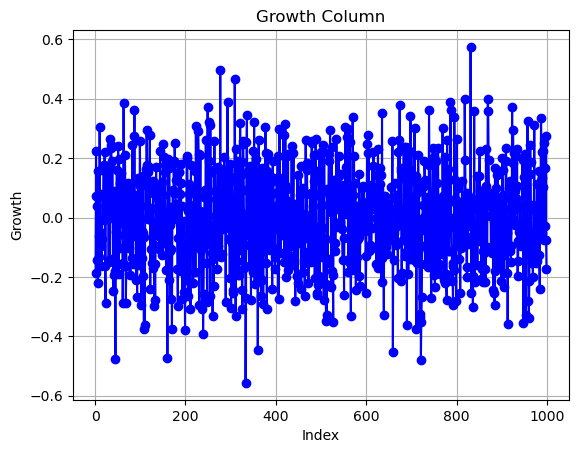

In [38]:
# Step 1: Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Step 2: Load your DataFrame
# Assuming you have a CSV file, replace 'your_file.csv' with your actual file path

plt.plot(eg.df['grow'], marker='o', linestyle='-', color='b')
plt.title('Growth Column')
plt.xlabel('Index')
plt.ylabel('Growth')
plt.grid(True)
plt.show()